In [62]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from scipy.io import loadmat, savemat

In [5]:
perm_all = pd.read_csv('/mnt/e/Latent-Geo-Modeling/simulations_2D/perm_all.csv')
perm_all = np.moveaxis(np.array(perm_all).reshape(128,128,-1), -1, 0)
print(perm_all.shape)

(1000, 128, 128)


In [15]:
facies = []
for root, dirs, files in tqdm(os.walk('/mnt/e/MLTrainingImages/')):
    for file in files:
        if file.endswith('.npy'):
            f = np.load(os.path.join(root, file))
            facies.append(f)
facies = np.array(facies)
print(facies.shape)

318it [02:15,  2.35it/s] 


(318, 8388608, 1)


In [42]:
facies = np.moveaxis(facies.reshape(-1, 256, 256, 128), 1, 2)
print(facies.shape)

(318, 256, 256, 128)


In [112]:
facies_all = np.zeros((318, 4, 128, 128))
for i in range(318):
    facies_all[i,0,...] = resize(facies[i,...,16], (128, 128), anti_aliasing=True, preserve_range=True)
    facies_all[i,1,...] = resize(facies[i,...,48], (128, 128), anti_aliasing=True, preserve_range=True)
    facies_all[i,2,...] = resize(facies[i,...,80], (128, 128), anti_aliasing=True, preserve_range=True)
    facies_all[i,3,...] = resize(facies[i,...,112], (128, 128), anti_aliasing=True, preserve_range=True)

facies_all = facies_all.reshape(-1, 128, 128)[136:1136]
print(facies_all.shape)

(1000, 128, 128)


In [165]:
facies_norm = MinMaxScaler((0.5, 1.5)).fit_transform(facies_all.reshape(-1, 128*128)).reshape(-1, 128, 128)
print('{}:  {:.3f} | {:.3f}'.format(facies_norm.shape, facies_norm.min(), facies_norm.max()))

perm_norm = np.log10(10**perm_all * 1000**facies_norm) - 2
#perm_norm = MinMaxScaler((perm_all.min(), perm_all.max())).fit_transform(perm_norm.reshape(-1, 128*128)).reshape(-1, 128, 128)
print('{}: {:.3f} | {:.3f}'.format(perm_norm.shape, perm_norm.min(), perm_norm.max()))

poro_norm = 10**((perm_all - 7)/10) * facies_norm - 0.05
poro_norm = MinMaxScaler((0.03, 0.30)).fit_transform(poro_norm.reshape(-1, 128*128)).reshape(-1, 128, 128)
print('{}:  {:.3f} | {:.3f}'.format(poro_norm.shape, poro_norm.min(), poro_norm.max()))

(1000, 128, 128):  0.500 | 1.500
(1000, 128, 128): -3.839 | 5.213
(1000, 128, 128):  0.030 | 0.300


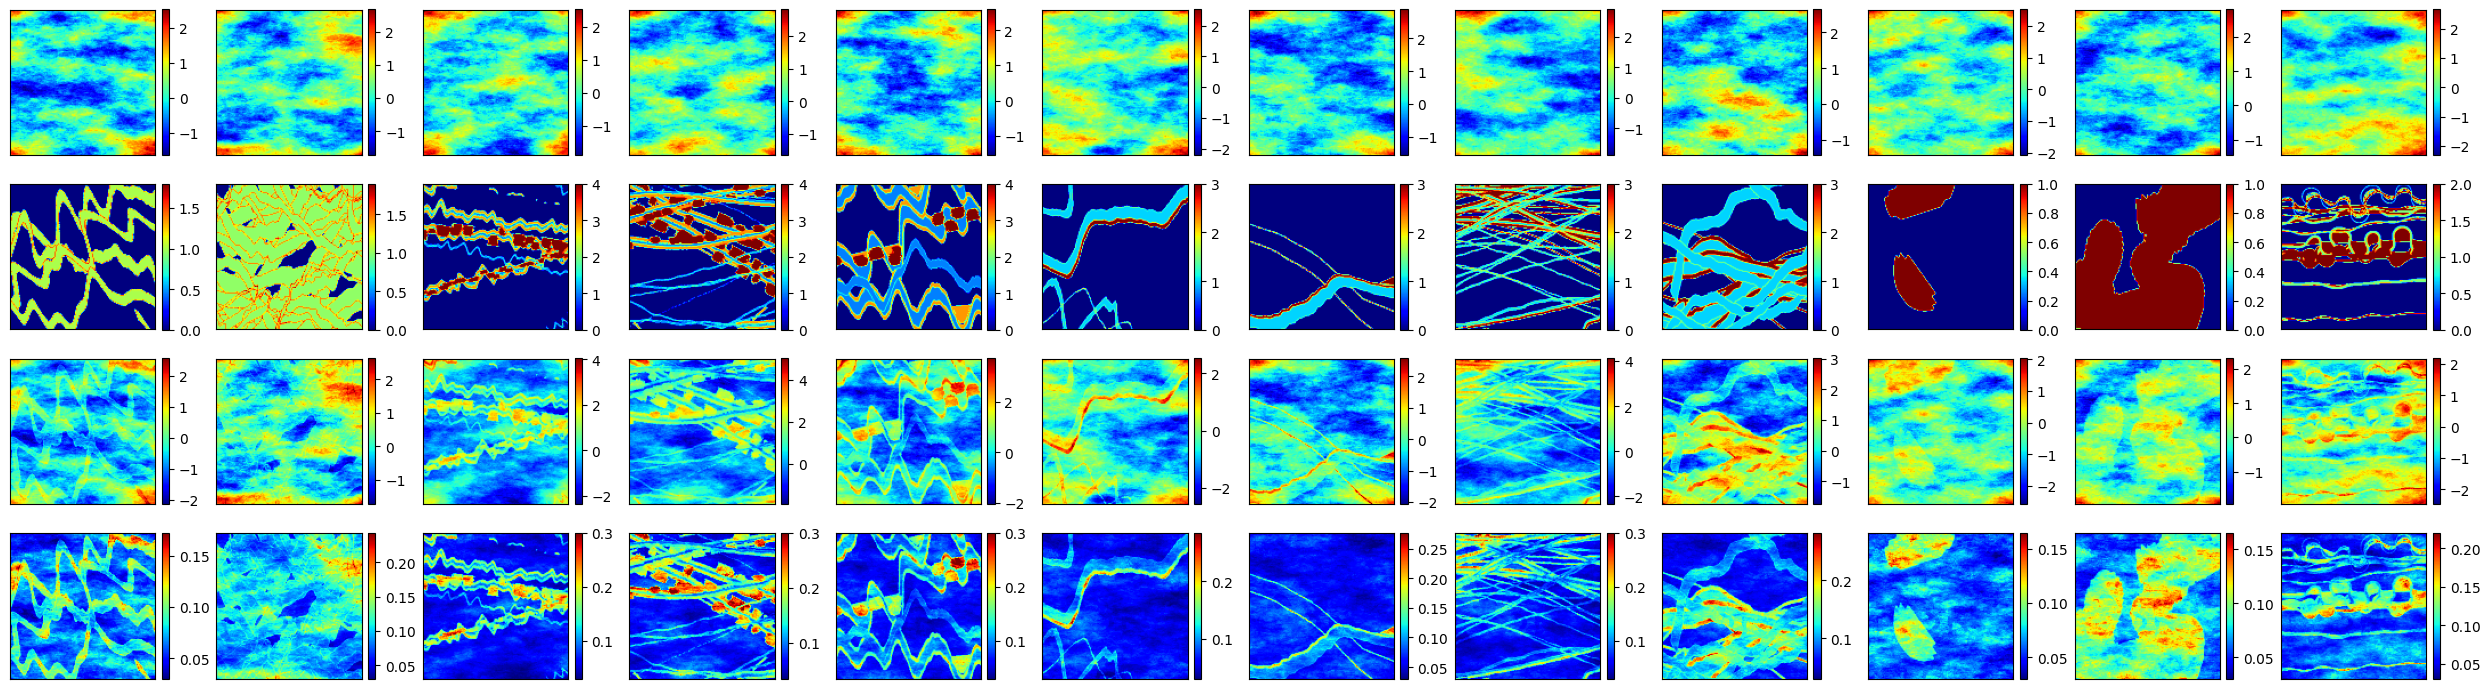

In [166]:
fig, axs = plt.subplots(4, 12, figsize=(25, 7))
for j in range(12):
    ax1, ax2, ax3, ax4 = axs[0, j], axs[1, j], axs[2,j], axs[3,j]
    k = j * 66

    im1 = ax1.imshow(perm_all[k], cmap='jet')
    im2 = ax2.imshow(facies_all[k], cmap='jet')
    im3 = ax3.imshow(perm_norm[k], cmap='jet')
    im4 = ax4.imshow(poro_norm[k], cmap='jet')
    ims = [im1, im2, im3, im4]

    for i in range(4):
        axs[i,j].set(xticks=[], yticks=[])
        plt.colorbar(ims[i], ax=axs[i,j], pad=0.04, fraction=0.046)

plt.tight_layout()
plt.show()

In [167]:
np.savez('por_perm_facies_1000x128x128.npz', perm_orig=perm_all, facies_orig=facies_all, perm_norm=perm_norm, poro_norm=poro_norm, facies_norm=facies_norm)

savemat('por_perm_facies_1000x128x128.mat', {
    'perm_orig': perm_all,
    'facies_orig': facies_all,
    'perm_norm': perm_norm,
    'poro_norm': poro_norm,
    'facies_norm': facies_norm
})

***
# END